In [1]:
from collections import namedtuple
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Node = namedtuple('Node', ['dim', 'split_value', 'left', 'right'])

In [3]:
def entropy_over_region(y):
    """
    Calculates the entropy in a single region of the partition space
    :param y: 1D of length n representing the labels in one region m
    :return: The entropy
    
    """
    n, = y.shape
    if n == 0.0:
        return 0.0
    y_unique = np.unique(y)
    ent = 0.0
    for label in y_unique:
        c = (y == label).sum()
        if c == 0:
            continue
        ent += ((c / n) * np.log2(c / n))
    return -ent

In [4]:
def weighted_entropy(regions, N):
    if N == 0.0:
        return 0.0
    total = 0.0
    for region in regions:
        m, = region.shape
        total += (m / N * entropy_over_region(region))
    return total

In [5]:
def find_best_split(X, y):
    n, d = X.shape
    assert n != 0

    # we find split with the highest information gain
    axis_best, s_best, i_best, E_best = None, None, None, np.inf
    for axis in range(d):
        coords = X[:, axis]
        key = np.argsort(coords)
        y_sorted = y[key]
        C_sorted = coords[key]
        for i in range(n - 1):
            if C_sorted[i] == C_sorted[i+1]:
                continue
            E = weighted_entropy([y_sorted[:i+1], y_sorted[i+1:]], n)
            if E < E_best:
                E_best, axis_best, i_best, s_best = E, axis, i+1, (C_sorted[i] + C_sorted[i + 1]) / 2
    return (axis_best, s_best, i_best, E_best)

In [6]:
def build_leaf(y):
    # return the label with the highest count
    y_unique, counts = np.unique(y, return_counts=True)
    return y_unique[np.argmax(counts)]
    
def build_tree(X, y, leaf_size=5, depth=1000):
    n, d = X.shape
    assert n != 0
    if n <= leaf_size or depth == 0:
        return build_leaf(y)
    else:
        axis_best, s_best, i, ent = find_best_split(X, y)
        indices = np.argsort(X[:, axis_best])
        X_sorted = X[indices]
        y_sorted = y[indices]
        
        if ent == 0.0:
            return build_leaf(y_sorted)

        return Node(axis_best,
                    s_best,
                    build_tree(X_sorted[:i, :], y_sorted[:i], leaf_size, depth - 1),
                    build_tree(X_sorted[i:, :], y_sorted[i:], leaf_size, depth - 1))

In [7]:
def predict(root: Node, x):
    if not isinstance(root, Node):
        return root
    else:
        if x[root.dim] < root.split_value:
            return predict(root.left, x)
        else:
            return predict(root.right, x)

In [8]:
def predict_vector(root: Node, xs):
    return np.array([predict(root, x) for x in xs])

In [9]:
def eval_classifier(leaf_size, X_train, y_train, X_test, y_test):
    root = build_tree(X_train, y_train, leaf_size)
    n, _ = X_test.shape
    return np.sum(predict_vector(root, X_test) == y_test) * (1 / n)

In [10]:
def cross_validate(leafsize, X, y, k, verbose=False):
    n, d = X.shape
    X_y = np.concatenate([X, y[:, np.newaxis]], axis=1)
    np.random.shuffle(X_y)
    X, y = X_y[:, :d], X_y[:, d]

    s_data = np.array_split(X, k, axis=0)
    s_labels = np.array_split(y, k)

    score_sum = 0
    for i in range(k):
        X_train = np.concatenate(s_data[:i] + s_data[i + 1:], axis=0)
        y_train = np.concatenate(s_labels[:i] + s_labels[i + 1:], axis=0)
        X_test = np.array(s_data[i])
        y_test = np.array(s_labels[i])
        score = eval_classifier(leafsize, X_train, y_train,
                                     X_test, y_test)
        score_sum += score
        if verbose:
            display(f" iteration {i}, score: {score}")
    return score_sum / k

In [11]:
iris_X, iris_y = load_iris(return_X_y=True)
print(iris_X.shape)
print(iris_y.shape)

(150, 4)
(150,)


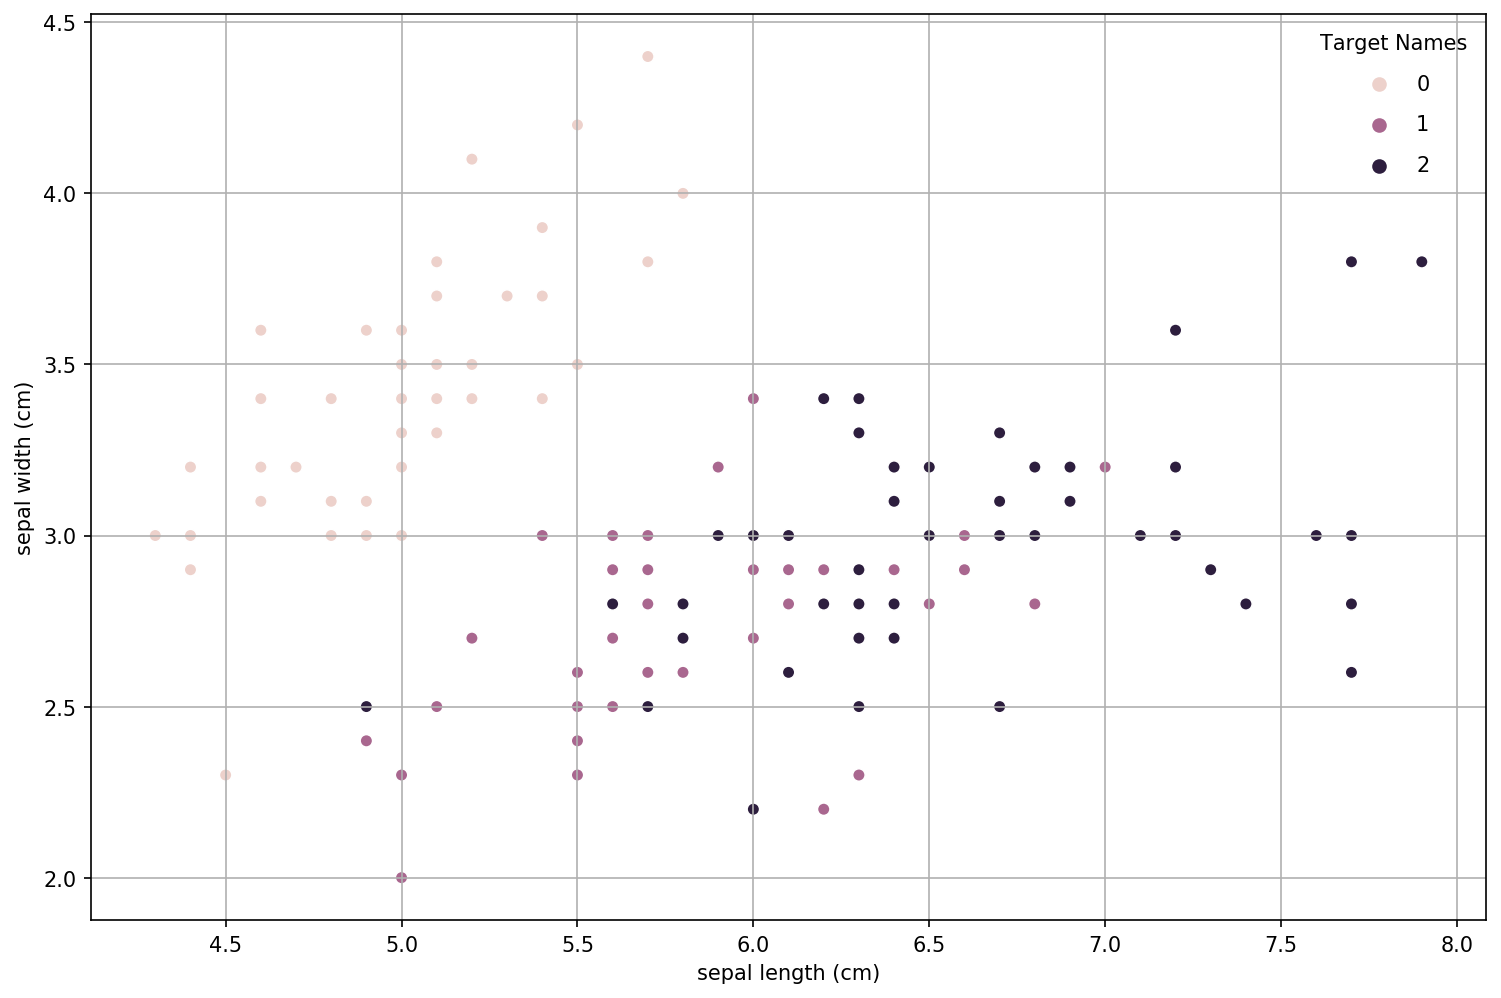

In [12]:
# plot two features
plt.figure(num=None, figsize=(12, 8), dpi=150, facecolor='w', edgecolor='k')

# Scatter the points, using size and color but no label
lines = sns.scatterplot(x=iris_X[:, 0], y=iris_X[:, 1], hue=iris_y)

plt.grid(True)

plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")

plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Target Names')
plt.show()

In [13]:
# Split the data into training/testing sets
iris_X_train = iris_X[:-20]
iris_X_test = iris_X[-20:]

# Split the targets into training/testing sets
iris_y_train = iris_y[:-20]
iris_y_test = iris_y[-20:]

In [14]:
iris_X_train.shape, iris_X_test.shape

((130, 4), (20, 4))

In [15]:
iris_y_train.shape, iris_y_test.shape

((130,), (20,))

In [16]:
load_iris().feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

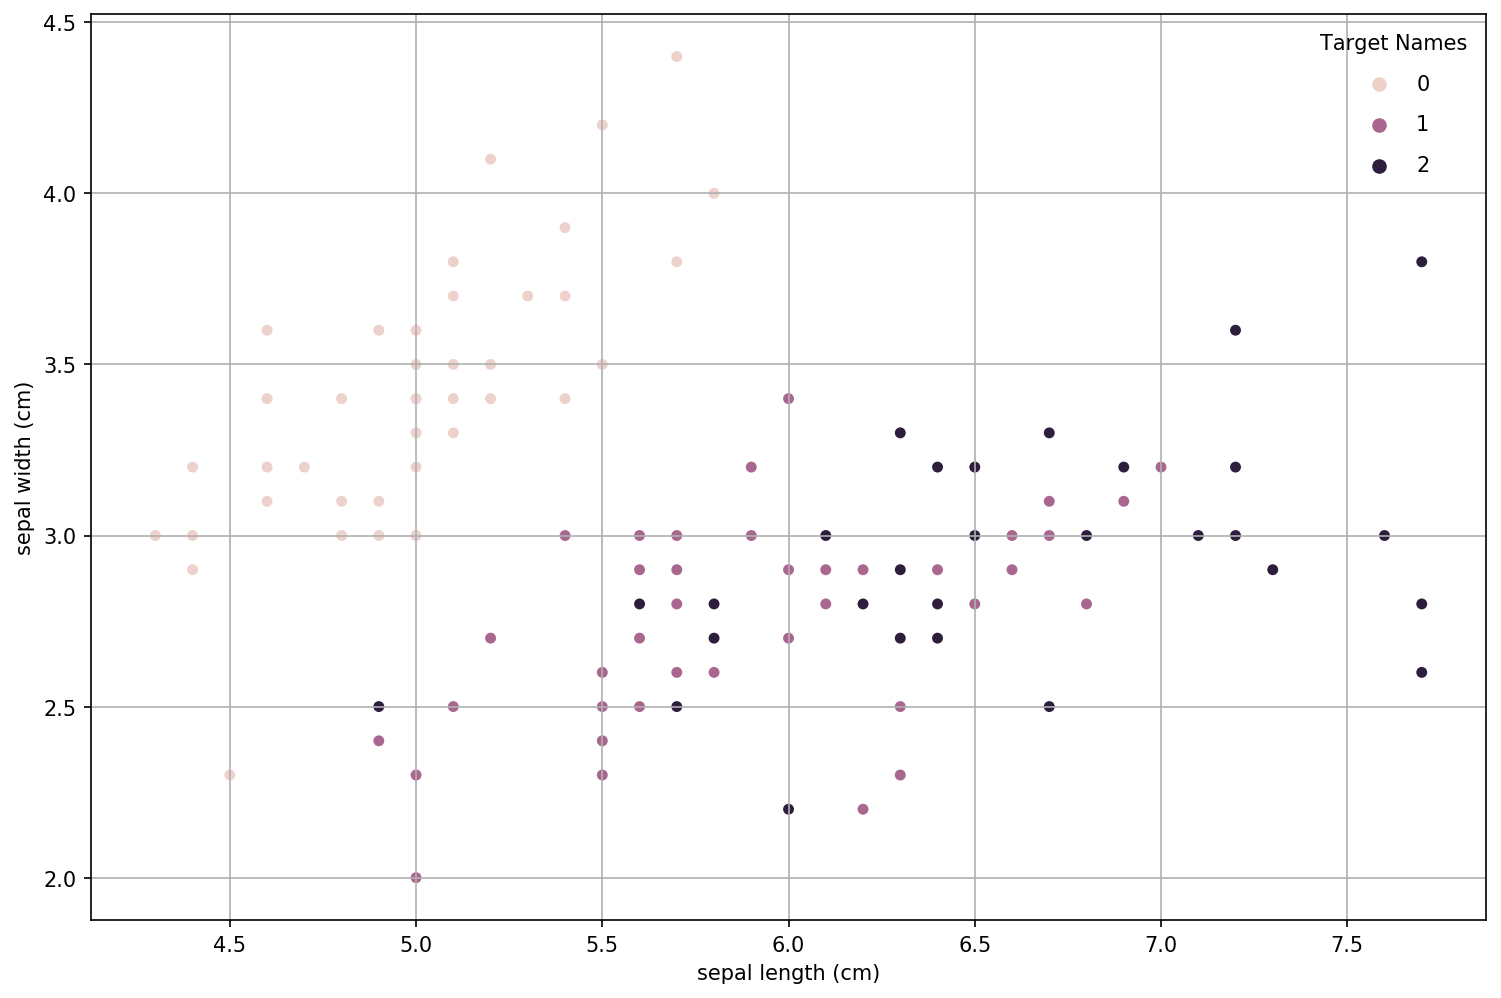

In [17]:
# plot two features
plt.figure(num=None, figsize=(12, 8), dpi=150, facecolor='w', edgecolor='k')

# Scatter the points, using size and color but no label
lines = sns.scatterplot(x=iris_X_train[:, 0], y=iris_X_train[:, 1], hue=iris_y_train)

plt.grid(True)

plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")

plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Target Names')
plt.show()

In [18]:
tree = build_tree(iris_X_train, iris_y_train, leaf_size=1)

In [19]:
(eval_classifier(3, iris_X_train, iris_y_train, iris_X_test, iris_y_test))

0.9500000000000001

In [20]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
cross_val_score(clf, iris_X_train, iris_y_train, cv=10)

array([1.        , 1.        , 0.92307692, 1.        , 0.92307692,
       0.92307692, 0.84615385, 1.        , 1.        , 0.84615385])

In [21]:
clf.fit(iris_X_train, iris_y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [22]:
find_best_split(iris_X_train, iris_y_train)

(2, 2.45, 50, 0.5873440017999785)

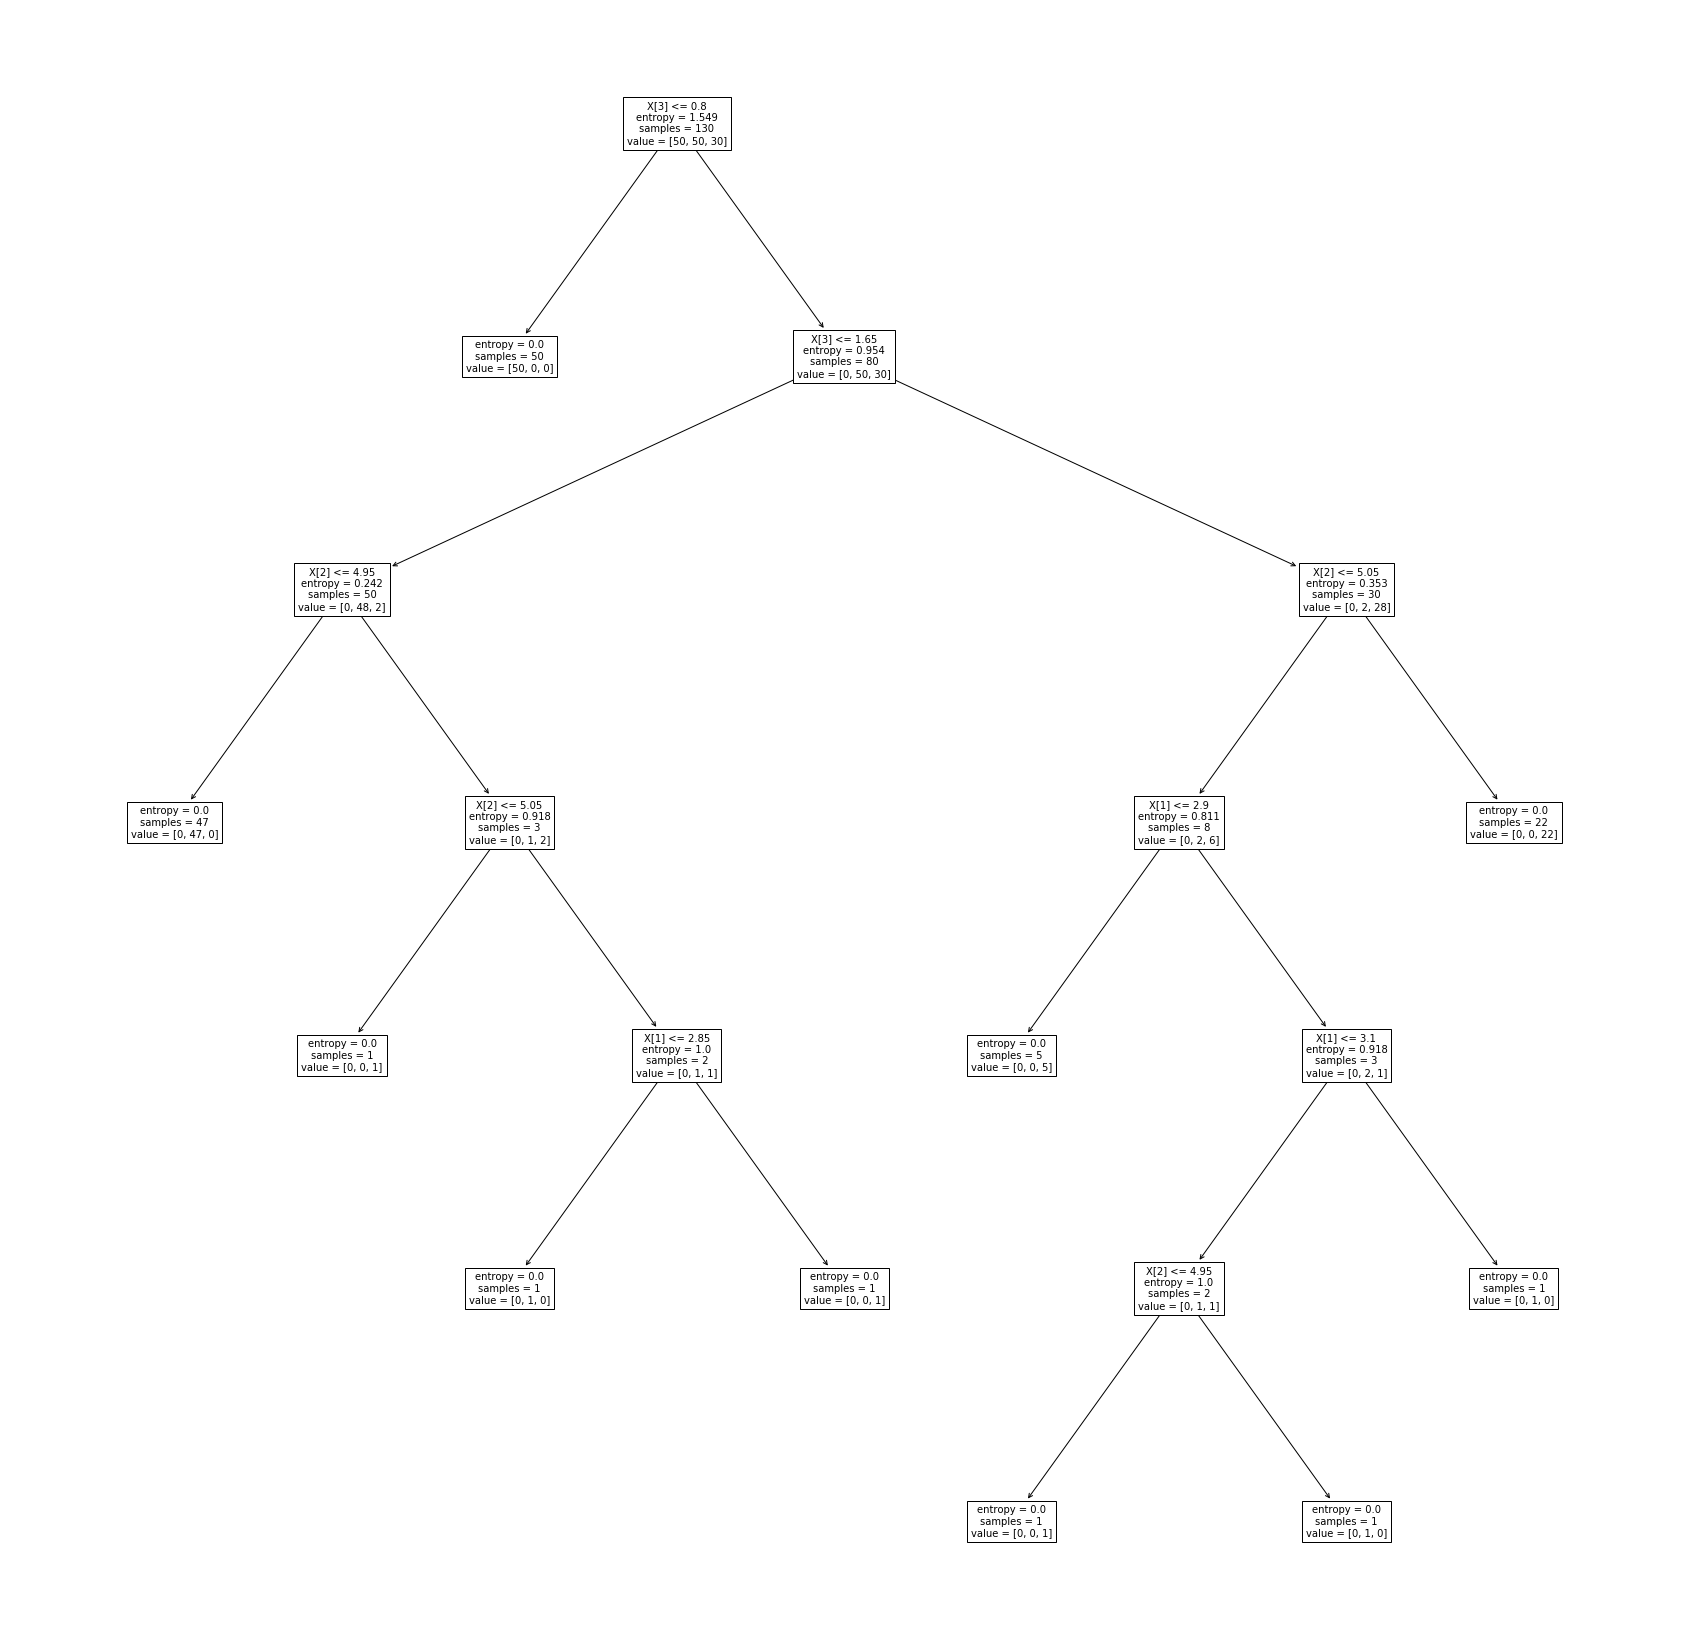

In [23]:
fig, ax = plt.subplots(figsize=(30, 30))
plot = plot_tree(clf, fontsize=10, ax=ax)

In [24]:
(predict_vector(tree, iris_X_test) == iris_y_test).sum() / len(iris_y_test)

0.85

In [25]:
iris_y_test

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [26]:
(clf.predict(iris_X_test) == iris_y_test).sum() / len(iris_y_test)

0.9

In [27]:
import sklearn.model_selection

In [28]:
dir(sklearn.model_selection)

['BaseCrossValidator',
 'GridSearchCV',
 'GroupKFold',
 'GroupShuffleSplit',
 'KFold',
 'LeaveOneGroupOut',
 'LeaveOneOut',
 'LeavePGroupsOut',
 'LeavePOut',
 'ParameterGrid',
 'ParameterSampler',
 'PredefinedSplit',
 'RandomizedSearchCV',
 'RepeatedKFold',
 'RepeatedStratifiedKFold',
 'ShuffleSplit',
 'StratifiedKFold',
 'StratifiedShuffleSplit',
 'TimeSeriesSplit',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_search',
 '_split',
 '_validation',
 'check_cv',
 'cross_val_predict',
 'cross_val_score',
 'cross_validate',
 'fit_grid_point',
 'learning_curve',
 'permutation_test_score',
 'train_test_split',
 'validation_curve']

In [91]:
?sklearn.model_selection.train_test_split

In [92]:
?sklearn.model_selection.cross_validate

In [93]:
?sklearn.model_selection.RepeatedKFold

In [94]:
?sklearn.model_selection.GridSearchCV